<a href="https://colab.research.google.com/github/UA51/Final-Project_Code/blob/main/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries Importing

In [2]:
# Importing essential libraries
import os  # Provides functions to interact with the operating system
import numpy as np  # For numerical operations
import pandas as pd  # For handling and manipulating data/
# Importing TensorFlow for building and training deep learning models
import tensorflow as tf
# Importing metrics from scikit-learn for model evaluation
from sklearn.metrics import *
# Importing libraries for visualization
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For advanced visualizations built on top of Matplotlib
# Importing tools from TensorFlow Keras for data preprocessing and model creation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image augmentation
from tensorflow.keras import layers, models, regularizers, callbacks  # Essential Keras modules for creating models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Setting up an automatic tuning parameter for TensorFlow's data pipeline
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Reading the CSV file containing folds information into a Pandas DataFrame
folds_dataframe = pd.read_csv('/content/drive/MyDrive/Dataset/Folds.csv')
# Path to the directory containing the BreaKHis dataset
images_directory = '/content/drive/MyDrive/Dataset/BreaKHis_v1/'
# Defining the tumor types present in the dataset
tumor_types = ['benign', 'malignant']


# Removing Duplicates from the Dataset

In [ ]:
# Remove duplicate entries based on the 'image_filename' column, keeping only the first occurrence
dataframe = folds_dataframe.drop_duplicates(subset='filename', keep='first')

# Print the new shape of the DataFrame after removing duplicates
print(f'Updated DataFrame shape: {dataframe.shape}')

# Rename the 'filename' column to 'image_path' for clarity
dataframe = dataframe.rename(columns={'filename': 'image_path'})

# Extract tumor type labels from the file path and assign them to a new 'label' column
dataframe['label'] = dataframe['image_path'].apply(lambda path: path.split('/')[3])

# Map the tumor type labels to numeric values and store them in a new column 'label_numeric'
dataframe['label_numeric'] = dataframe['label'].apply(lambda label: tumor_types.index(label))

# Extract only the file name from the full path and assign it to a new column 'file_name'
dataframe['file_name'] = dataframe['image_path'].apply(lambda path: path.split('/')[-1])

# Prepend the base directory path to the 'image_path' column for the full path to each image
dataframe['image_path'] = dataframe['image_path'].apply(lambda path: images_directory + path)

# Display the first three rows of the updated DataFrame
dataframe.head(3)


Updated DataFrame shape: (7909, 4)


,fold,mag,grp,image_path,label,label_numeric,file_name
0,1,100,train,/content/drive/MyDrive/Datasets/Images/BreaKHi...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,/content/drive/MyDrive/Datasets/Images/BreaKHi...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,/content/drive/MyDrive/Datasets/Images/BreaKHi...,benign,0,SOB_B_A-14-22549AB-100-003.png


# Spliting Dataset into Training and Testing

In [ ]:
# Randomly select 600 samples (300 per tumor type) for the test set
test_data = dataframe.groupby('label').sample(n=300)

# Remove the test samples from the dataset to create the training set
train_data = dataframe.drop(test_data.index).reset_index(drop=True)

# Reset indices for the test set
test_data = test_data.reset_index(drop=True)

# Randomly select 20% of the training data for the validation set
validation_data = train_data.sample(frac=0.2)

# Remove the validation samples from the training set
train_data = train_data.drop(validation_data.index).reset_index(drop=True)

# Reset indices for the validation set
validation_data = validation_data.reset_index(drop=True)

# Assign dataset identifiers ('train', 'valid', 'test') to each set
test_data['dataset'] = 'test'
train_data['dataset'] = 'train'
validation_data['dataset'] = 'valid'

# Display the label counts for each subset
print('Training Set:')
print(train_data['label'].value_counts())

print('\nValidation Set:')
print(validation_data['label'].value_counts())

print('\nTest Set:')
print(test_data['label'].value_counts())


Training Set:
label
malignant    4134
benign       1713
Name: count, dtype: int64

Validation Set:
label
malignant    995
benign       467
Name: count, dtype: int64

Test Set:
label
benign       300
malignant    300
Name: count, dtype: int64


# UpSampling Dataset to Remove Class Imbalance

In [ ]:
# Upsample the training dataset
max_count = np.max(train_data['label'].value_counts())
train_data = train_data.groupby('label').sample(n=max_count, replace=True).reset_index(drop=True)

# Display counts to verify upsampling
print(train_data['label'].value_counts())


label
benign       4134
malignant    4134
Name: count, dtype: int64


# Data Augmentation

In [ ]:
# Convert the 'label_numeric' column to string type for compatibility with categorical class mode
train_data['label_numeric'] = train_data['label_numeric'].astype(str)
validation_data['label_numeric'] = validation_data['label_numeric'].astype(str)

# Configure data augmentation for the training set
train_image_augmenter = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to the range [0, 1]
    rotation_range=15,  # Randomly rotate images by up to 15 degrees
    width_shift_range=0.15,  # Randomly shift images horizontally by up to 15% of width
    height_shift_range=0.15,  # Randomly shift images vertically by up to 15% of height
    shear_range=0.1,  # Apply random shearing transformations
    zoom_range=0.25,  # Randomly zoom in or out on images by up to 25%
    horizontal_flip=True,  # Allow random horizontal flipping
    fill_mode='nearest'  # Fill in missing pixels using the nearest available value
)

# Configure a simpler data generator for the validation set with only rescaling
validation_image_augmenter = ImageDataGenerator(rescale=1./255)

# Create a data generator for the training set with augmented images
train_data_generator = train_image_augmenter.flow_from_dataframe(
    dataframe=train_data,  # Use the training data DataFrame
    directory='',  # No base directory since paths are full
    x_col='image_path',  # Column containing the file paths
    y_col='label_numeric',  # Column containing the numeric labels
    target_size=(200, 200),  # Resize images to 200x200 pixels
    batch_size=64,  # Number of images per batch
    class_mode='sparse'  # Use sparse labels for numerical classes
)

# Create a data generator for the validation set with rescaled images
validation_data_generator = validation_image_augmenter.flow_from_dataframe(
    dataframe=validation_data,  # Use the validation data DataFrame
    directory='',  # No base directory since paths are full
    x_col='image_path',  # Column containing the file paths
    y_col='label_numeric',  # Column containing the numeric labels
    target_size=(200, 200),  # Resize images to 200x200 pixels
    batch_size=64,  # Number of images per batch
    class_mode='sparse'  # Use sparse labels for numerical classes
)


Found 8268 validated image filenames belonging to 2 classes.
Found 1462 validated image filenames belonging to 2 classes.


# Defining the Simple CNN Model

In [ ]:
# Define the updated model
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(200, 200, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dropout(0.25))

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dropout(0.3))

# Third convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dropout(0.35))

# Fourth convolutional block
model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dropout(0.4))

# Fifth convolutional block (reduce pooling)
model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((1, 1), padding='same'))  # Reduce pooling to avoid shrinking dimensions
model.add(layers.Dropout(0.4))

# Flatten and fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))  # Output layer for 2 classes


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compiling the Model

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 200, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 25, 25, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 512)         │              

 Total params: 23,758,658 (90.63 MB)

 Trainable params: 23,755,906 (90.62 MB)

 Non-trainable params: 2,752 (10.75 KB)

# Model Training

In [ ]:
# Define callback functions to improve training efficiency
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,  # Stop training if validation loss doesn't improve for 5 consecutive epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.3,  # Reduce the learning rate by a factor of 0.3
    patience=3,  # Reduce learning rate if no improvement in validation loss for 3 epochs
    verbose=1  # Print messages when learning rate is reduced
)

# Train the model with the defined callbacks
history = model.fit(
    train_data_generator,  # Training data generator
    epochs=50,  # Number of epochs to train
    validation_data=validation_data_generator,  # Validation data generator
    callbacks=[early_stopping, reduce_lr],  # Use the callbacks for early stopping and learning rate reduction
    verbose=1  # Print detailed training progress
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 1303s 9s/step - accuracy: 0.7426 - loss: 2.5117 - val_accuracy: 0.6922 - val_loss: 5.1018 - learning_rate: 0.0010
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.7882 - loss: 2.0366 - val_accuracy: 0.7114 - val_loss: 1.8875 - learning_rate: 0.0010
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.8269 - loss: 1.4412 - val_accuracy: 0.6922 - val_loss: 1.7958 - learning_rate: 0.0010
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.8505 - loss: 1.0804 - val_accuracy: 0.6929 - val_loss: 3.2002 - learning_rate: 0.0010
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.8662 - loss: 0.8643 - val_accuracy: 0.7031 - val_loss: 1.0182 - learning_rate: 0.0010
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.8862 - loss: 0.6886 - val_accuracy: 0.6101 - val_loss: 1.7681 - learning_rate: 0.0010
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.8892 - loss: 0.6027 - val

# Training Curves

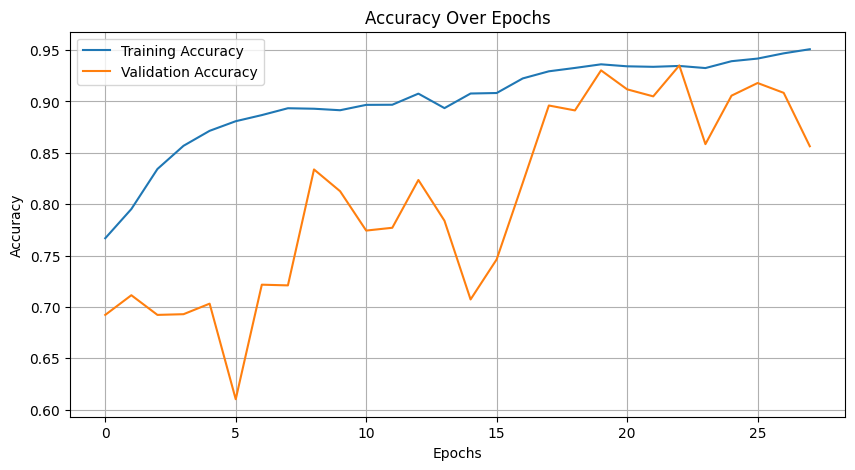

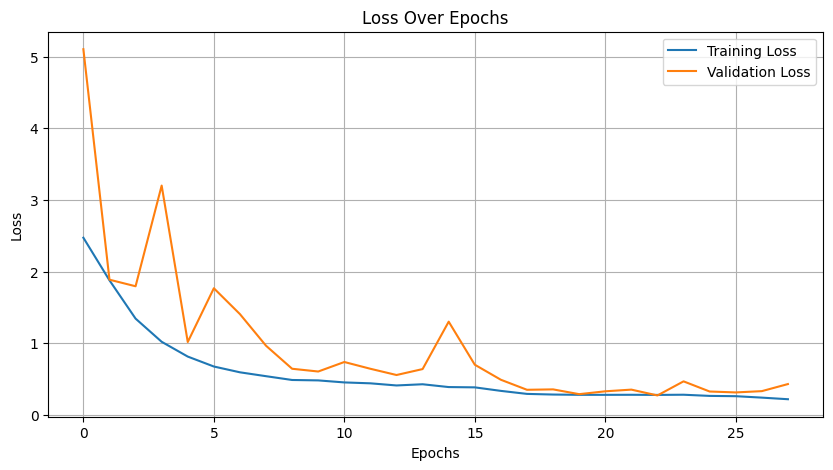

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluating The Simple CNN Model

Found 600 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 890ms/step - accuracy: 0.9083 - loss: 0.3537
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 906ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       300
           1       0.89      0.97      0.93       300

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



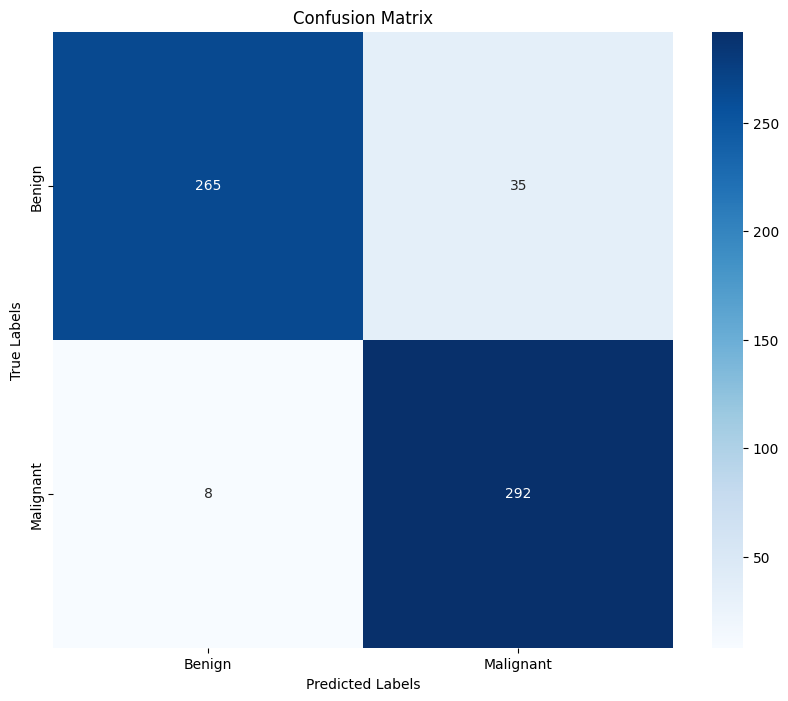

In [ ]:
test_data['label_numeric'] = test_data['label_numeric'].astype(str)
# Configure a simpler data generator for the test set with only rescaling
test_image_augmenter = ImageDataGenerator(rescale=1./255)

# Create a data generator for the test set with rescaled images
test_data_generator = test_image_augmenter.flow_from_dataframe(
    dataframe=test_data,  # Use the test data DataFrame
    directory='',  # No base directory since paths are full
    x_col='image_path',  # Column containing the file paths
    y_col='label_numeric',  # Column containing the numeric labels
    target_size=(200, 200),  # Resize images to 200x200 pixels
    batch_size=64,  # Number of images per batch
    class_mode='sparse',  # Use sparse labels for numerical classes
    shuffle=False  # Ensure no shuffling for test data to maintain order
)

# Evaluate the model on the test data generator
test_loss, test_accuracy = model.evaluate(test_data_generator, verbose=1)

# Get predictions for the test data
test_data_generator.reset()  # Ensure generator is reset before making predictions
predictions = model.predict(test_data_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Get the true labels from the test data generator
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print classification report
print("Classification Report:")
print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

class_names = ['Benign', 'Malignant']
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Defining the Complex CNN Model

In [ ]:
# Define the updated model with two Conv2D layers per block
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(200, 200, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dropout(0.25))

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dropout(0.3))

# Third convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dropout(0.35))

# Fourth convolutional block
model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dropout(0.4))

# Fifth convolutional block (reduce pooling)
model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((1, 1), padding='same'))  # Reduce pooling to avoid shrinking dimensions
model.add(layers.Dropout(0.4))

# Flatten and fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))  # Output layer for 2 classes


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compiling the Model

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 200, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 200, 200, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 200, 200, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 50, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,906,274 (102.64 MB)

 Trainable params: 26,901,538 (102.62 MB)

 Non-trainable params: 4,736 (18.50 KB)

# Model Training

In [ ]:
# Define callback functions to improve training efficiency
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,  # Stop training if validation loss doesn't improve for 5 consecutive epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.3,  # Reduce the learning rate by a factor of 0.3
    patience=3,  # Reduce learning rate if no improvement in validation loss for 3 epochs
    verbose=1  # Print messages when learning rate is reduced
)

# Train the model with the defined callbacks
history = model.fit(
    train_data_generator,  # Training data generator
    epochs=50,  # Number of epochs to train
    validation_data=validation_data_generator,  # Validation data generator
    callbacks=[early_stopping, reduce_lr],  # Use the callbacks for early stopping and learning rate reduction
    verbose=1  # Print detailed training progress
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 4626s 32s/step - accuracy: 0.7231 - loss: 3.6190 - val_accuracy: 0.6806 - val_loss: 4.7105 - learning_rate: 0.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8106 - loss: 3.1125 - val_accuracy: 0.6806 - val_loss: 3.5768 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.8390 - loss: 2.4124 - val_accuracy: 0.6902 - val_loss: 2.7069 - learning_rate: 0.0010
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.8560 - loss: 1.8575 - val_accuracy: 0.8365 - val_loss: 1.8656 - learning_rate: 0.0010
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.8671 - loss: 1.4746 - val_accuracy: 0.8256 - val_loss: 1.7593 - learning_rate: 0.0010
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.8651 - loss: 1.1915 - val_accuracy: 0.8345 - val_loss: 1.1882 - learning_rate: 0.0010
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.8690 - loss: 1.0166 - va

# Training Curves

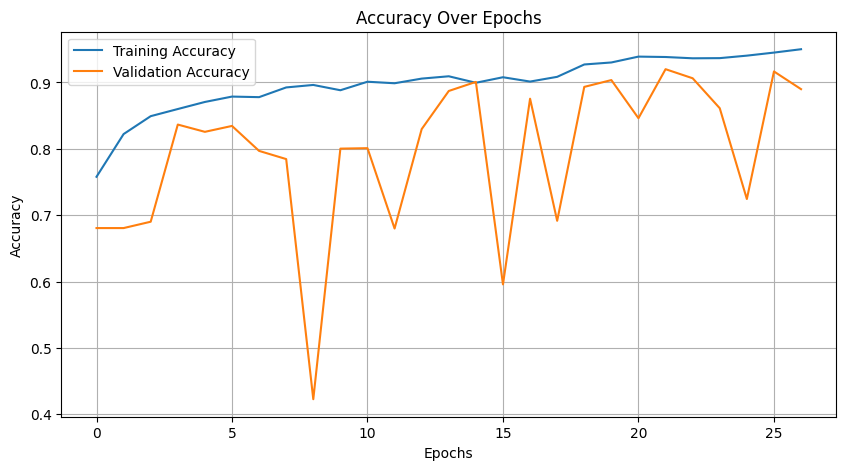

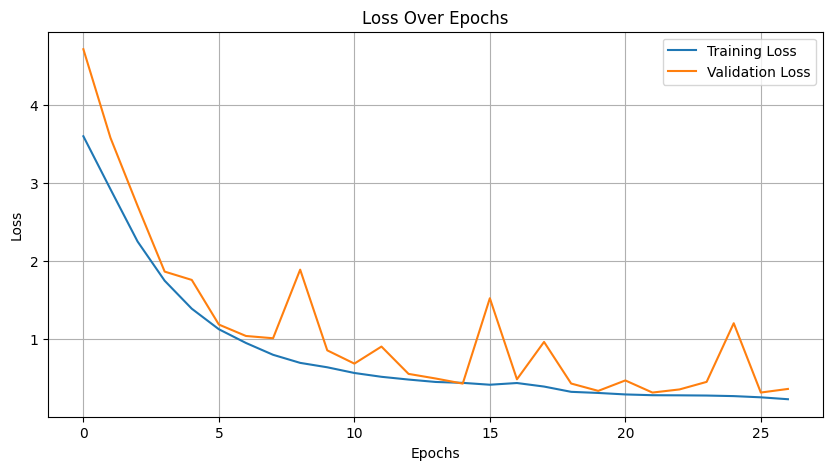

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluating the Model

Found 600 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 394s 44s/step - accuracy: 0.8677 - loss: 0.3947
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       300
           1       0.85      0.97      0.91       300

    accuracy                           0.90       600
   macro avg       0.91      0.90      0.90       600
weighted avg       0.91      0.90      0.90       600



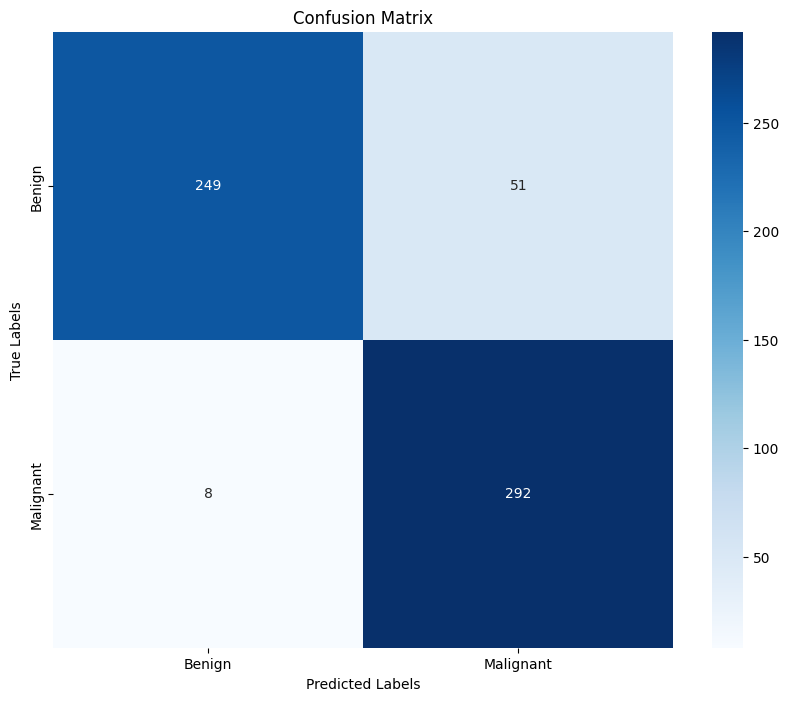

In [ ]:
test_data['label_numeric'] = test_data['label_numeric'].astype(str)
# Configure a simpler data generator for the test set with only rescaling
test_image_augmenter = ImageDataGenerator(rescale=1./255)

# Create a data generator for the test set with rescaled images
test_data_generator = test_image_augmenter.flow_from_dataframe(
    dataframe=test_data,  # Use the test data DataFrame
    directory='',  # No base directory since paths are full
    x_col='image_path',  # Column containing the file paths
    y_col='label_numeric',  # Column containing the numeric labels
    target_size=(200, 200),  # Resize images to 200x200 pixels
    batch_size=64,  # Number of images per batch
    class_mode='sparse',  # Use sparse labels for numerical classes
    shuffle=False  # Ensure no shuffling for test data to maintain order
)

# Evaluate the model on the test data generator
test_loss, test_accuracy = model.evaluate(test_data_generator, verbose=1)

# Get predictions for the test data
test_data_generator.reset()  # Ensure generator is reset before making predictions
predictions = model.predict(test_data_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Get the true labels from the test data generator
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print classification report
print("Classification Report:")
print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

class_names = ['Benign', 'Malignant']
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Importing VGG19 Model

In [ ]:
# Load the VGG19 model without the top fully connected layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Fine Tunning the Model

In [ ]:
# Unfreeze the last two layers in the base model
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Add new fully connected layers on top of the base model
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation='softmax')(x)  # Output layer for 2 classes
# Create the new model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the VGG19 Model

In [ ]:
# Define callback functions to improve training efficiency
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,  # Stop training if validation loss doesn't improve for 5 consecutive epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.3,  # Reduce the learning rate by a factor of 0.3
    patience=3,  # Reduce learning rate if no improvement in validation loss for 3 epochs
    verbose=1  # Print messages when learning rate is reduced
)

# Train the model with the defined callbacks
history = model.fit(
    train_data_generator,  # Training data generator
    epochs=50,  # Number of epochs to train
    validation_data=validation_data_generator,  # Validation data generator
    callbacks=[early_stopping, reduce_lr],  # Use the callbacks for early stopping and learning rate reduction
    verbose=1  # Print detailed training progress
)


Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.5416 - loss: 1.3537 - val_accuracy: 0.7709 - val_loss: 0.9242 - learning_rate: 1.0000e-04
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.6919 - loss: 0.9894 - val_accuracy: 0.8085 - val_loss: 0.7856 - learning_rate: 1.0000e-04
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.7692 - loss: 0.8307 - val_accuracy: 0.8208 - val_loss: 0.7093 - learning_rate: 1.0000e-04
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.7903 - loss: 0.7491 - val_accuracy: 0.8393 - val_loss: 0.6632 - learning_rate: 1.0000e-04
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.8112 - loss: 0.6868 - val_accuracy: 0.8468 - val_loss: 0.6039 - learning_rate: 1.0000e-04
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8204 - loss: 0.6310 - val_accuracy: 0.8434 - val_loss: 0.5964 - learning_rate: 1.0000e-04
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - acc

# Training Curves For VGG19

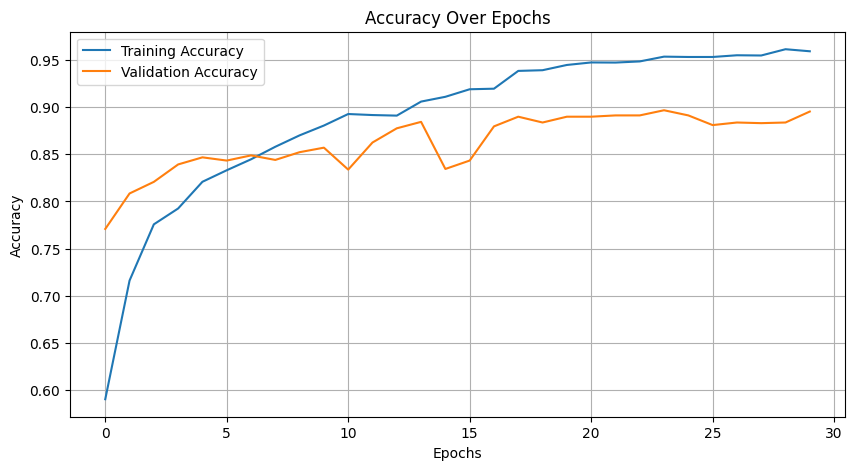

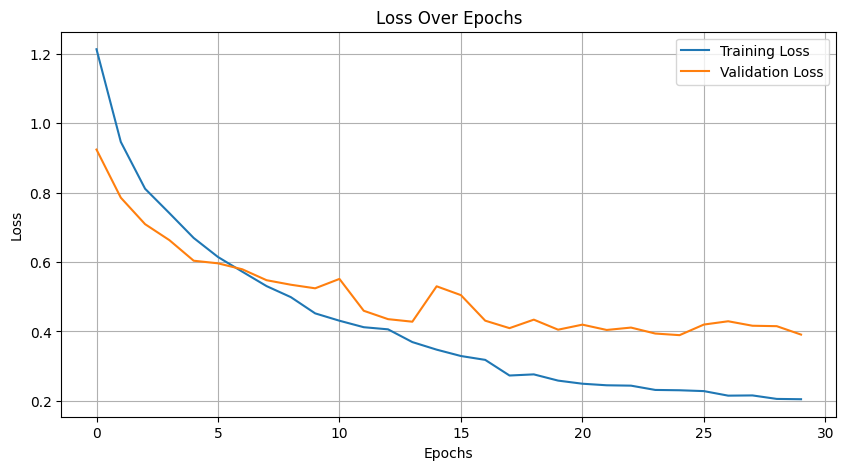

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluating VGG19 Model

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8670 - loss: 0.4721
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 974ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       300
           1       0.85      0.95      0.90       300

    accuracy                           0.89       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.89      0.89       600



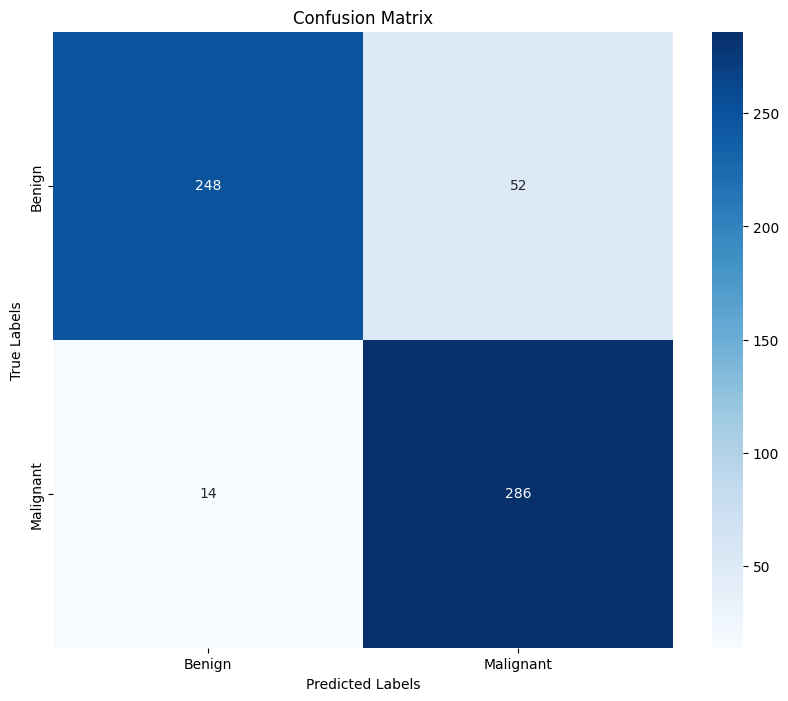

In [ ]:
# Evaluate the model on the test data generator
test_loss, test_accuracy = model.evaluate(test_data_generator, verbose=1)

# Get predictions for the test data
test_data_generator.reset()  # Ensure generator is reset before making predictions
predictions = model.predict(test_data_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Get the true labels from the test data generator
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print classification report
print("Classification Report:")
print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

class_names = ['Benign', 'Malignant']
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()